In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
import matplotlib.cm as cm
import json
from tqdm import tqdm
from PIL import Image
import os
import gc
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

# Tomographic Reconstruction of Basketball Movement Data - Pacers @ Raptors, October 28th, 2015

In this case study, we will be using SportsVU movement data alongside play by play data to construct meaningful visualizations of The Toronto Raptors offense. The analysis below details the data cleaning, preprocessing, visualization and machine learning used to produce spatial reconstruction using ball movement data. The end goal is to reconstruct offensive threat given the ball's position on the court using naive models (conditional probability, movement heatmaps) and interpretable machine learning models outlined in a study conducted by Jairo Diaz-Rodriguez and his peers. This notebook aims to be an extension of the methods used in the study (link below).

Code and analysis completed by Jonathan Channer under the supervision of Dr. Jairo Diaz-Rodriguez.

Play by play data: [Kaggle](https://www.kaggle.com/datasets/brains14482/nba-playbyplay-and-shotdetails-data-19962021?select=nbastats_2015.csv)  
Play by play parsing: [Ryan Davis](https://github.com/rd11490/NBA_Tutorials/tree/master/play_by_play_parser)   
SportsVU game logs: [Kostya Linou](https://github.com/linouk23/NBA-Player-Movements/tree/master)  
Tomographic reconstruction of a disease transmission landscape via GPS recorded random paths: [Article](https://arxiv.org/pdf/2404.04455)

## Reading the Data

Using the play by play parser created by Ryan Davis, we get a dataframe that outlines possession times for each team, allowing us to filter possesions by team and time they occured. There was a glaring issue with our data in that the possesions were not tracked corrrectly and the possesion times were terminating as they were beginning. To fix this, we used inspection to see that the possession times were off by one row, so using the [.shift()](http://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) function to ammend this.

To augment the data we determine our target variable by using the `team2_points`, which corrrelates to the amount of points the Raptors scored on that possesion. Alongside this, we also adjust the possession end and start times to be relative to their quarter. Lastly, we check some basic information such as the score and the proportion of succesful possesions to ensure our preliminary dataframe is in a good spot to begin parsing the movement data.

In [4]:
df = pd.read_csv("0021500009_possessions.csv")

In [5]:
df

team1_id  team1_player1  team1_player2  team1_player3  team1_player4  \
0    1610612754         101133         101139         101145         201588   
1    1610612754         101133         101139         101145         201588   
2    1610612754         101133         101139         101145         201588   
3    1610612754         101133         101139         101145         201588   
4    1610612754         101133         101139         101145         201588   
..          ...            ...            ...            ...            ...   
200  1610612754         101139         101145         201588         201941   
201  1610612754         101139         101145         201588         201941   
202  1610612754         101139         101145         201588         201941   
203  1610612754         101139         201588         201941         202331   
204  1610612754         101139         201588         201941         202331   

     team1_player5    team2_id  team2_player1  team2_player2  team2_player3  \
0           202331  1610612761           2449         200768         201942   
1           202331  1610612761           2449         200768         201942   
2           202331  1610612761           2449         200768         201942   
3           202331  1610612761           2449         200768         201942   
4           202331  1610612761           2449         200768         201942   
..             ...         ...            ...            ...            ...   
200         202331  1610612761         200768         201942         201960   
201         202331  1610612761         200768         201942         201960   
202         202331  1610612761         200768         201942         201960   
203         202730  1610612761         200768         201942         201960   
204         202730  1610612761         200768         201942         201960   

     team2_player4  team2_player5   game_id  period  possession_start  \
0           201960         202685  21500009       1                 0   
1           201960         202685  21500009       1                32   
2           201960         202685  21500009       1                38   
3           201960         202685  21500009       1                50   
4           201960         202685  21500009       1                75   
..             ...            ...       ...     ...               ...   
200         202685         202709  21500009       4              2853   
201         202685         202709  21500009       4              2862   
202         202685         202709  21500009       4              2866   
203         202685         202709  21500009       4              2868   
204         202685         202709  21500009       4              2868   

     possession_end  team1_points  team2_points  possession_team  
0                17             0             2       1610612761  
1                33             0             0       1610612754  
2                38             0             0       1610612761  
3                50             2             0       1610612754  
4                75             0             2       1610612761  
..              ...           ...           ...              ...  
200            2861             0             0       1610612754  
201            2862             0             2       1610612761  
202            2867             2             0       1610612754  
203            2868             0             1       1610612761  
204            2874             0             0       1610612754  

[205 rows x 19 columns]

In [6]:
# possesion times are off. The end of one possesion would lead into the beginning of the other team's possesion.
# use .shift()
df["possession_start"] = df["possession_end"].shift(1)
df = df.fillna(0)
df.head()

team1_id  team1_player1  team1_player2  team1_player3  team1_player4  \
0  1610612754         101133         101139         101145         201588   
1  1610612754         101133         101139         101145         201588   
2  1610612754         101133         101139         101145         201588   
3  1610612754         101133         101139         101145         201588   
4  1610612754         101133         101139         101145         201588   

   team1_player5    team2_id  team2_player1  team2_player2  team2_player3  \
0         202331  1610612761           2449         200768         201942   
1         202331  1610612761           2449         200768         201942   
2         202331  1610612761           2449         200768         201942   
3         202331  1610612761           2449         200768         201942   
4         202331  1610612761           2449         200768         201942   

   team2_player4  team2_player5   game_id  period  possession_start  \
0         201960         202685  21500009       1               0.0   
1         201960         202685  21500009       1              17.0   
2         201960         202685  21500009       1              33.0   
3         201960         202685  21500009       1              38.0   
4         201960         202685  21500009       1              50.0   

   possession_end  team1_points  team2_points  possession_team  
0              17             0             2       1610612761  
1              33             0             0       1610612754  
2              38             0             0       1610612761  
3              50             2             0       1610612754  
4              75             0             2       1610612761

In [7]:
df_raptors = df[df["possession_team"] == 1610612761]

In [8]:
df_raptors.head()

team1_id  team1_player1  team1_player2  team1_player3  team1_player4  \
0  1610612754         101133         101139         101145         201588   
2  1610612754         101133         101139         101145         201588   
4  1610612754         101133         101139         101145         201588   
6  1610612754         101133         101139         101145         201588   
8  1610612754         101133         101139         101145         201588   

   team1_player5    team2_id  team2_player1  team2_player2  team2_player3  \
0         202331  1610612761           2449         200768         201942   
2         202331  1610612761           2449         200768         201942   
4         202331  1610612761           2449         200768         201942   
6         202331  1610612761           2449         200768         201942   
8         202331  1610612761           2449         200768         201942   

   team2_player4  team2_player5   game_id  period  possession_start  \
0         201960         202685  21500009       1               0.0   
2         201960         202685  21500009       1              33.0   
4         201960         202685  21500009       1              50.0   
6         201960         202685  21500009       1              88.0   
8         201960         202685  21500009       1             110.0   

   possession_end  team1_points  team2_points  possession_team  
0              17             0             2       1610612761  
2              38             0             0       1610612761  
4              75             0             2       1610612761  
6              98             0             2       1610612761  
8             115             0             0       1610612761

In [9]:
print(sum(df["team1_points"]), " - " ,sum(df["team2_points"]))

99  -  106


In [10]:
times_score = df_raptors[["period", "possession_start", "possession_end", "team2_points"]]
possessions = [x for x in range(1, len(times_score) + 1)]

times_score["possession_number"] = possessions

In [11]:
times_score

period  possession_start  possession_end  team2_points  possession_number
0         1               0.0              17             2                  1
2         1              33.0              38             0                  2
4         1              50.0              75             2                  3
6         1              88.0              98             2                  4
8         1             110.0             115             0                  5
..      ...               ...             ...           ...                ...
195       4            2808.0            2830             2                 99
197       4            2843.0            2843             2                100
199       4            2853.0            2853             1                101
201       4            2861.0            2862             2                102
203       4            2867.0            2868             1                103

[103 rows x 5 columns]

In [12]:
# chaging possesion times relative to the quarter, not as a portion of the whole time left

updated_times_score = times_score.copy()

mask = updated_times_score["period"] > 1

updated_times_score.loc[mask, "possession_start"] = (
    updated_times_score.loc[mask, "period"] * 720 - updated_times_score.loc[mask, "possession_start"]
)

updated_times_score.loc[mask, "possession_end"] = (
    updated_times_score.loc[mask, "period"] * 720 - updated_times_score.loc[mask, "possession_end"]
)

updated_times_score.loc[updated_times_score["period"] == 1, "possession_start"] = (
    720 - updated_times_score.loc[updated_times_score["period"] == 1, "possession_start"]
)

updated_times_score.loc[updated_times_score["period"] == 1, "possession_end"] = (
    720 - updated_times_score.loc[updated_times_score["period"] == 1, "possession_end"]
)

updated_times_score["scored"] = (updated_times_score["team2_points"] > 0).astype(int)

In [13]:
updated_times_score

period  possession_start  possession_end  team2_points  \
0         1             720.0             703             2   
2         1             687.0             682             0   
4         1             670.0             645             2   
6         1             632.0             622             2   
8         1             610.0             605             0   
..      ...               ...             ...           ...   
195       4              72.0              50             2   
197       4              37.0              37             2   
199       4              27.0              27             1   
201       4              19.0              18             2   
203       4              13.0              12             1   

     possession_number  scored  
0                    1       1  
2                    2       0  
4                    3       1  
6                    4       1  
8                    5       0  
..                 ...     ...  
195                 99       1  
197                100       1  
199                101       1  
201                102       1  
203                103       1  

[103 rows x 6 columns]

In [14]:
updated_times_score.tail(10)

# TO DO
# parse JSON file for positional data of the ball in the time interval of possesion_start and possession_end and create a matrix with it and the outcome (scored points)
# Maybe find a way to determine if the ball is a shot using the z-axis to clean up the output 

period  possession_start  possession_end  team2_points  \
185       4             220.0             204             0   
187       4             197.0             181             0   
189       4             167.0             149             0   
191       4             138.0             118             2   
193       4             100.0              89             3   
195       4              72.0              50             2   
197       4              37.0              37             2   
199       4              27.0              27             1   
201       4              19.0              18             2   
203       4              13.0              12             1   

     possession_number  scored  
185                 94       0  
187                 95       0  
189                 96       0  
191                 97       1  
193                 98       1  
195                 99       1  
197                100       1  
199                101       1  
201                102       1  
203                103       1

In [15]:
sum(updated_times_score["scored"])/len(updated_times_score)

0.49514563106796117

## Parsing the Movement Data

The movement data is stored in JSON files, so it is easily parsable. The issue that arises is that there are a minimum of 720 x 25 x 4 = 72,000 data points. This is an underestimate given timeouts, commercial breaks and stoppages in plays. Because of this, we end up with a massive output dataframe that does not represent our data well. To mitigate these issues, we filter the data using the `possesion_start` and `possesion_end` columns to create a time interval for each possesion that we want to collect movement data for. In addition to using filter intervals, we also take the last sample from repeated times in each quarter to help us get the best point of reference for when play resumes. This rersulted in a reasonably sized and clean dataframe that contains the time, possesion number, (x, y, z) coordinates of the ball, and our target variable `scored`.

In [17]:
file = open("0021500009.json")

data = json.load(file)

print(data["quarters"]["1"][0][5][0])

print(data["quarters"]["1"][0][2])

file.close()

del data
gc.collect()

# data["quarters"]["quarter_num"][moment][index 2: time] -> comparison for possesion time interval
# data["quarters"]["quarter_num"][moment][index 5: ball/player positional info][index 0: ball data][indices 2, 3, 4: x, y and z positions respectively] -> position data to be written to feature matrix

[-1, -1, 37.04728, 15.02163, 6.44393]
719.0


0

In [18]:
# Load JSON data only once
with open("0021500009.json", "r") as f:
    tracking_data = json.load(f)

# Optional: subset to a specific period to reduce load
periods_to_check = updated_times_score['period'].unique().astype(str)

# Preload quarters once (avoid repeated dict lookup)
quarters = tracking_data.get("quarters", {})

# Store filtered ball data
ball_pos_data = []

# Go row-by-row (each possession)
for _, row in tqdm(updated_times_score.iterrows(), total=len(updated_times_score), desc="Processing possessions"):
    period = str(int(row["period"]))
    start = row["possession_start"]
    end = row["possession_end"]
    possession = row["possession_number"],
    scored = row["scored"]

    # Skip if no data for that period
    moments = quarters.get(period, [])
    if not moments:
        continue

    # Use list comprehension for speed
    filtered_moments = [
        {
            "period": int(period),
            "time": moment[2],
            "x": moment[5][0][2],
            "y": moment[5][0][3],
            "z": moment[5][0][4],
            "possession_start": start,
            "possession_end": end,
            "possession_number": possession,
            "scored": scored
        }
        for moment in moments
        if isinstance(moment, list) and
           len(moment) > 5 and
           len(moment[5]) > 0 and
           end <= moment[2] <= start
    ]

    ball_pos_data.extend(filtered_moments)

# Create final DataFrame
ball_pos_df = pd.DataFrame(ball_pos_data)
print(f"Filtered {len(ball_pos_df)} moments across all possessions.")

# Optional: Save to disk to avoid re-running
print(ball_pos_df.shape)
print(ball_pos_df.columns)
print(ball_pos_df.head())
ball_pos_df.to_pickle("ball_pos_df.pkl")

# Clean up memory
del tracking_data, quarters, ball_pos_data
gc.collect()

Processing possessions: 100%|██████████| 103/103 [00:04<00:00, 23.08it/s]


Filtered 136952 moments across all possessions.
(136952, 9)
Index(['period', 'time', 'x', 'y', 'z', 'possession_start', 'possession_end',
       'possession_number', 'scored'],
      dtype='object')
   period    time         x         y        z  possession_start  \
0       1  719.00  37.04728  15.02163  6.44393             720.0   
1       1  718.96  36.30142  14.70948  6.12091             720.0   
2       1  718.92  35.67854  14.33637  5.70189             720.0   
3       1  718.88  34.84530  13.68251  5.15255             720.0   
4       1  718.84  34.18749  13.55080  4.64143             720.0   

   possession_end possession_number  scored  
0           703.0            (1.0,)     1.0  
1           703.0            (1.0,)     1.0  
2           703.0            (1.0,)     1.0  
3           703.0            (1.0,)     1.0  
4           703.0            (1.0,)     1.0  


0

In [19]:
ball_pos_df = pd.read_pickle("ball_pos_df.pkl")

In [20]:
ball_pos_df.describe()

period           time              x              y  \
count  136952.000000  136952.000000  136952.000000  136952.000000   
mean        2.492486     353.832079      50.662514      24.944460   
std         1.190129     204.757919      28.602053      10.960669   
min         1.000000       0.020000      -5.881400      -3.280070   
25%         1.000000     164.230000      23.626470      18.633940   
50%         2.000000     383.920000      55.098220      24.990450   
75%         4.000000     518.610000      75.648263      31.894670   
max         4.000000     720.000000      99.611200      52.800990   

                   z  possession_start  possession_end         scored  
count  136952.000000     136952.000000   136952.000000  136952.000000  
mean        4.499302        361.924419      345.003571       0.487755  
std         2.962260        205.237198      204.144433       0.499852  
min         0.000000         13.000000        0.000000       0.000000  
25%         2.691510        169.000000      162.000000       0.000000  
50%         3.812965        405.000000      377.000000       0.000000  
75%         5.313408        525.000000      517.000000       1.000000  
max        17.700760        720.000000      703.000000       1.000000

In [21]:
# Group and get last row index per group
ball_pos_df["row_index"] = ball_pos_df.index

last_rows_in_order = (
    ball_pos_df.groupby(["time", "period"], group_keys=False)
    .tail() # change this to adjust last samples collected
    .sort_values("row_index")
    .drop(columns="row_index")
    .reset_index(drop=True)
)

In [22]:
last_rows_in_order.to_csv("final.csv")
last_rows_in_order.head()
# Possession is a tuple for some reason. Coverting to appropriate dtypes.

period    time         x         y        z  possession_start  \
0       1  719.00  37.04728  15.02163  6.44393             720.0   
1       1  718.96  36.30142  14.70948  6.12091             720.0   
2       1  718.92  35.67854  14.33637  5.70189             720.0   
3       1  718.88  34.84530  13.68251  5.15255             720.0   
4       1  718.84  34.18749  13.55080  4.64143             720.0   

   possession_end possession_number  scored  
0           703.0            (1.0,)     1.0  
1           703.0            (1.0,)     1.0  
2           703.0            (1.0,)     1.0  
3           703.0            (1.0,)     1.0  
4           703.0            (1.0,)     1.0

In [23]:
last_rows_in_order['possession_number'] = last_rows_in_order['possession_number'].apply(lambda x: int(x[0]) if isinstance(x, tuple) else x)
last_rows_in_order["scored"] = last_rows_in_order["scored"].convert_dtypes(convert_integer = True)

last_rows_in_order.describe()

period          time             x             y             z  \
count  92354.000000  92354.000000  92354.000000  92354.000000  92354.000000   
mean       2.438606    371.180613     49.194209     25.406442      4.082943   
std        1.174675    200.290207     25.497675     11.507610      2.734187   
min        1.000000      0.020000     -5.623690     -1.328760      0.000000   
25%        1.000000    194.760000     28.994910     17.074497      2.451030   
50%        2.000000    401.320000     51.568700     24.957925      3.532645   
75%        4.000000    528.030000     68.919380     34.817380      4.675040   
max        4.000000    720.000000     99.345540     50.564640     17.700760   

       possession_start  possession_end  possession_number    scored  
count      92354.000000    92354.000000       92354.000000   92354.0  
mean         379.517184      361.527026          50.869567  0.408439  
std          200.462132      199.970849          29.028675  0.491548  
min           13.000000        0.000000           1.000000       0.0  
25%          197.000000      184.000000          26.000000       0.0  
50%          419.000000      382.000000          49.000000       0.0  
75%          531.000000      522.000000          79.000000       1.0  
max          720.000000      703.000000         103.000000       1.0

In [24]:
# We now have our movement dataframe. From here we will:
# 1. Create an adjacency matrix of the court using numpy and PIL
# 2. Vectorize our movement data
# 3. Create our GLM with sigmoid as the input into a -log inverse minimization problem with total variation to apply smoothness
# 4. Map the output to our court
# 5. Troubleshoot and optimize

In [25]:
# Heatmap by possession -> Naive visualization
# How to discretize -> Start small, get bigger (proportional court sizes, 10x20)
# Adjacency matrix for movement data (count of movement through each square during a possession)
# Create our GLM with sigmoid (uh oh) as the input into a -log inverse minimization problem with total variation to apply smoothness (Augmentation? Bootstrapping?)
# Confidence intervals after resampling
# Naive output -> split x-matrix into target groups (y = 1, y = 0), calculate probability score per square
# Per quarter analysis

In [26]:
last_rows_in_order.isna().sum()

period               0
time                 0
x                    0
y                    0
z                    0
possession_start     0
possession_end       0
possession_number    0
scored               0
dtype: int64

In [27]:
last_rows_in_order.to_pickle("cleaned_df")

## Ball Movement Visualizations

Now we begin with visualizing our data. Because we are using basketball data, we want to map our movements directly onto a court image using the `Image`, `numpy`, and `matplotlib` packages. Using `Image` and `matplotlib` is fairly straightforward, but using `numpy` required careful planning and statistical knowledge. Below is an outline of some of the mathematics used to discretize our court into an adjacency matrix and map ball movements to said matrix.

### Discretizing the Court

To begin, we needed to create a discrete map of our court. An NBA basketball court has the dimensions 94×50 feet, totaling 4700 sq ft. A matrix of this resolution is too computationally expensive to work with, so we reduce it to 200 units, or a 20×10 bin grid. What this creates is a set of discrete, uniform squares on a grid, which we will call $\mathcal{M}$, where each position $(i, j)$ corresponds to a grid cell:

$$
\mathcal{M} = \left\{ (i, j) \;\middle|\; 0 \leq i < 20,\; 0 \leq j < 10 \right\}
$$

With this grid, we map our movement data on the court to each position on the grid using the following transformation:

$$
\forall\; (x, y) \in \mathcal{D},\quad
x_{\text{bin}} = \min\left( \left\lfloor \frac{x}{L} \cdot N_x \right\rfloor,\; N_x - 1 \right), \quad
y_{\text{bin}} = \min\left( \left\lfloor \frac{y}{W} \cdot N_y \right\rfloor,\; N_y - 1 \right)
$$

Where:
- $\mathcal{D}$ is the dataset of continuous $(x, y)$ coordinates,
- $L$ and $W$ are the court length and width (94 and 50 feet),
- $N_x$ and $N_y$ are the number of bins in the horizontal and vertical directions,
- $\lfloor \cdot \rfloor$ is the floor function.

This transformation maps continuous positions into discrete bins in $\mathcal{M}$, aligning each data point with a grid cell.

We then construct a heatmap of ball movement, denoted by $\mathcal{H}$, and apply normalization to scale all values between 0 and 1:

$$
\mathcal{H}_{\text{norm}}(i, j) = \frac{\mathcal{H}(i, j)}{\max\limits_{(i, j) \in \mathcal{M}} \mathcal{H}(i, j)}
$$

This results in a normalized density heatmap where each grid position in $\mathcal{M}$ is associated with a score on the interval $(0, 1)$, representing the relative frequency of ball presence.


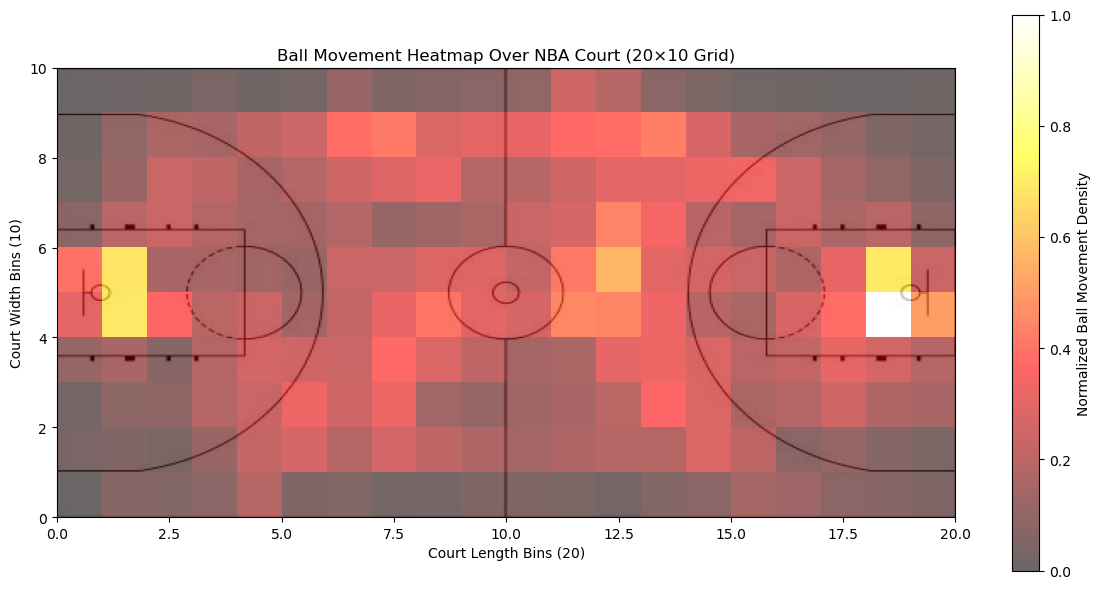

In [29]:
court_img = Image.open("court.jpg")

court_length = 94  # NBA court length in feet
court_width = 50   # NBA court width in feet

x_bins = 20  # number of horizontal bins
y_bins = 10  # number of vertical bins

# --- Discretize x and y positions into grid indices ---
last_rows_in_order['x_bin'] = np.clip((last_rows_in_order['x'] / court_length * x_bins).astype(int), 0, x_bins - 1)
last_rows_in_order['y_bin'] = np.clip((last_rows_in_order['y'] / court_width * y_bins).astype(int), 0, y_bins - 1)

# --- Create Heatmap Matrix ---
heatmap = np.zeros((x_bins, y_bins))
for _, row in last_rows_in_order.iterrows():
    heatmap[row['x_bin'], row['y_bin']] += 1

# Normalize (optional, for better visualization)
heatmap_normalized = heatmap / np.max(heatmap)

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 6))

# Show court image behind the heatmap
ax.imshow(court_img, extent=[0, x_bins, 0, y_bins], aspect='auto')

# Show heatmap overlay
heatmap_img = ax.imshow(
    heatmap_normalized.T,
    cmap='hot',
    origin='lower',
    extent=[0, x_bins, 0, y_bins],
    alpha=0.6  # transparency
)

# Add labels and colorbar
plt.colorbar(heatmap_img, ax=ax, label='Normalized Ball Movement Density')
ax.set_title("Ball Movement Heatmap Over NBA Court (20×10 Grid)")
ax.set_xlabel("Court Length Bins (20)")
ax.set_ylabel("Court Width Bins (10)")
plt.tight_layout()
plt.show()

In [30]:
# First plot above
# Rotate points 180 degrees if their y-axis is above 47 feet

last_rows_in_order = last_rows_in_order.drop(columns=["x_bin", "y_bin"])

In [31]:
movement_df = last_rows_in_order.copy()

mask = movement_df['x'] >= 47

movement_df.loc[mask, 'x'] = 94 - movement_df.loc[mask, 'x']
movement_df.loc[mask, 'y'] = 50 - movement_df.loc[mask, 'y']
# This is likely incorrrect...

In [32]:
movement_df.describe()

period          time             x             y             z  \
count  92354.000000  92354.000000  92354.000000  92354.000000  92354.000000   
mean       2.438606    371.180613     25.059789     24.786468      4.082943   
std        1.174675    200.290207     13.174519     11.512806      2.734187   
min        1.000000      0.020000     -5.623690     -0.836540      0.000000   
25%        1.000000    194.760000     13.406910     15.846920      2.451030   
50%        2.000000    401.320000     26.849330     24.823115      3.532645   
75%        4.000000    528.030000     36.182990     33.620200      4.675040   
max        4.000000    720.000000     46.999710     51.328760     17.700760   

       possession_start  possession_end  possession_number    scored  
count      92354.000000    92354.000000       92354.000000   92354.0  
mean         379.517184      361.527026          50.869567  0.408439  
std          200.462132      199.970849          29.028675  0.491548  
min           13.000000        0.000000           1.000000       0.0  
25%          197.000000      184.000000          26.000000       0.0  
50%          419.000000      382.000000          49.000000       0.0  
75%          531.000000      522.000000          79.000000       1.0  
max          720.000000      703.000000         103.000000       1.0

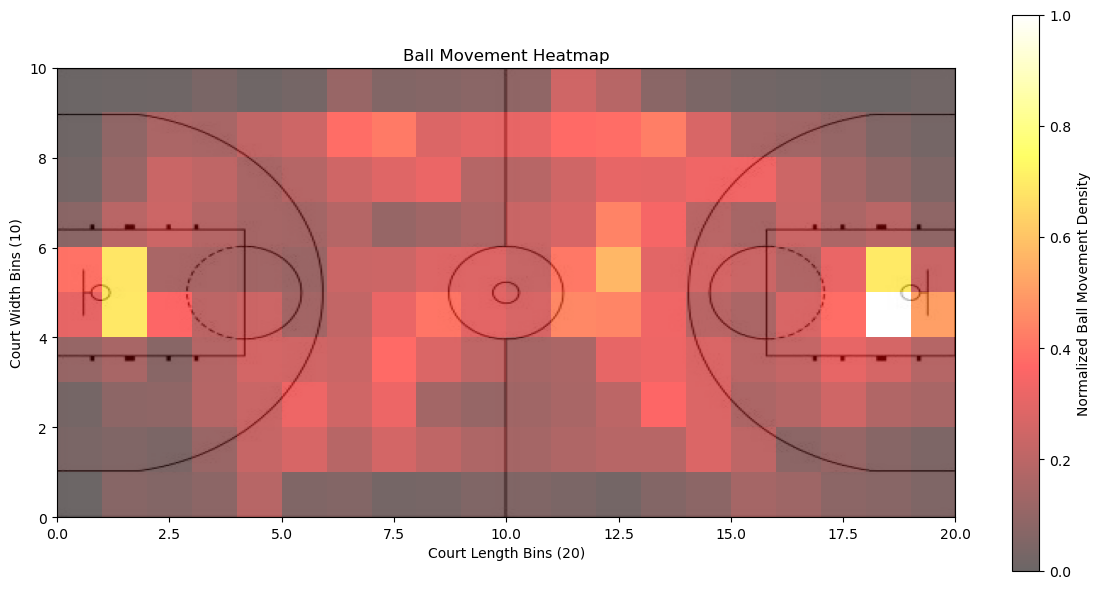

In [33]:
def heat(df, img, title = "Ball Movement Heatmap"):
    
    court_img = Image.open(img)

    court_length = 94  # NBA court length in feet (reduced)
    court_width = 50   # NBA court width in feet

    x_bins = 20  # number of horizontal bins
    y_bins = 10  # number of vertical bins
    
    # --- Discretize x and y positions into grid indices ---
    df['x_bin'] = np.clip((df['x'] / court_length * x_bins).astype(int), 0, x_bins - 1)
    df['y_bin'] = np.clip((df['y'] / court_width * y_bins).astype(int), 0, y_bins - 1)
    
    # --- Create Heatmap Matrix ---
    heatmap = np.zeros((x_bins, y_bins))
    for _, row in df.iterrows():
        heatmap[row['x_bin'], row['y_bin']] += 1
    
    # Normalize (optional, for better visualization)
    heatmap_normalized = heatmap / np.max(heatmap)
    
    # --- Plot ---
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Show court image behind the heatmap
    ax.imshow(court_img, extent=[0, x_bins, 0, y_bins], aspect='auto')
    
    # Show heatmap overlay
    heatmap_img = ax.imshow(
    heatmap_normalized.T,
    cmap='hot',
    origin='lower',
    extent=[0, x_bins, 0, y_bins],
    alpha=0.6  # transparency
    )
    
    # Add labels and colorbar
    plt.colorbar(heatmap_img, ax=ax, label='Normalized Ball Movement Density')
    ax.set_title(title)
    ax.set_xlabel("Court Length Bins (20)")
    ax.set_ylabel("Court Width Bins (10)")
    plt.tight_layout()
    plt.show()

heat(last_rows_in_order, "court.jpg", )

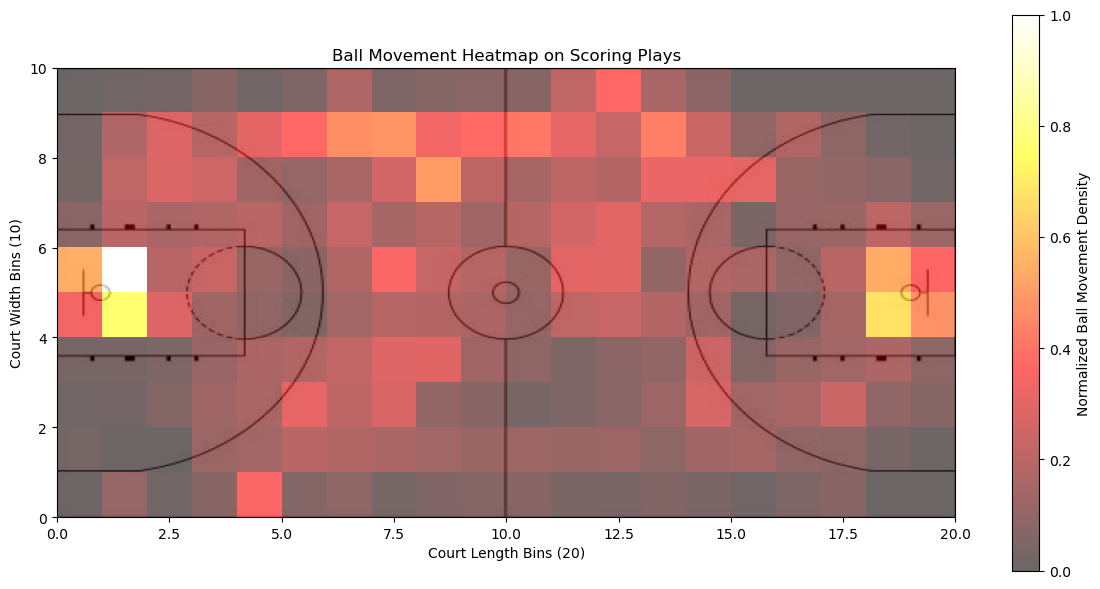

In [34]:
heat(last_rows_in_order[last_rows_in_order["scored"] == 1], "court.jpg", "Ball Movement Heatmap on Scoring Plays")

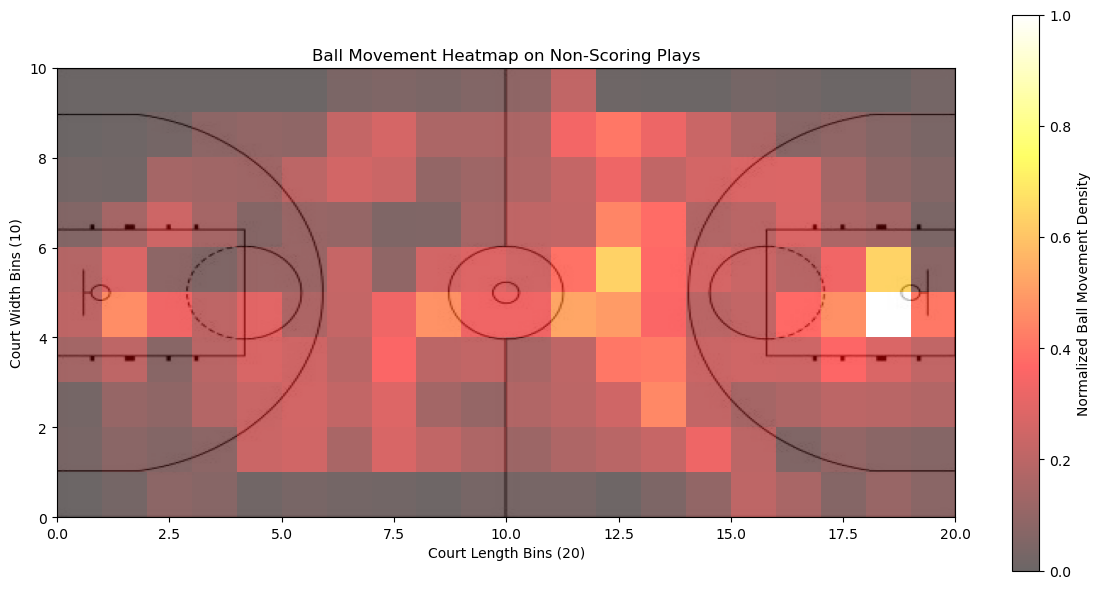

In [35]:
heat(last_rows_in_order[last_rows_in_order["scored"] == 0], "court.jpg", "Ball Movement Heatmap on Non-Scoring Plays")
# Why does the ball seem to have more movement on non-scoring plays?
# Less efficient movement?
# Maybe filter on the z-axis to remove some noise from the basket area?

## Conditional Scoring Probability by Sector

We estimate the conditional probability that a possession results in a score **given that the ball passed through a specific sector** of the court.

Let $\mathcal{M} = \left\{ (i, j) \mid 0 \leq i < N_x,\; 0 \leq j < N_y \right\}$ be the set of spatial bins on the court.

For each possession $p$, we define:
- $\mathcal{V}_p \subseteq \mathcal{M}$ as the set of all bins visited during possession $p$
- $s_p \in \{0, 1\}$ as an indicator whether the possession resulted in a score

We define two matrices:
- $T(i, j)$: total number of possessions that entered bin $(i, j)$
- $S(i, j)$: number of **scored** possessions that entered bin $(i, j)$

Then the estimated conditional scoring probability is:

$$
P(\text{score} \mid (i, j)) = 
\begin{cases}
\dfrac{S(i, j)}{T(i, j)} & \text{if } T(i, j) > 0 \\
0 & \text{otherwise}
\end{cases}
$$

This is implemented in code by iterating over all possessions, marking visited bins, and updating counts for $T(i, j)$ and $S(i, j)$. The resulting probability matrix is visualized as a heatmap overlayed on a court image.

We set the dimensions of the court to 20x10 for easy comparison to our ball movement heatmaps and included a filter in a second method to disregard any sectors that had less than $\mathcal{n}$ possesions move through it where $n \in \mathbb{N}$.

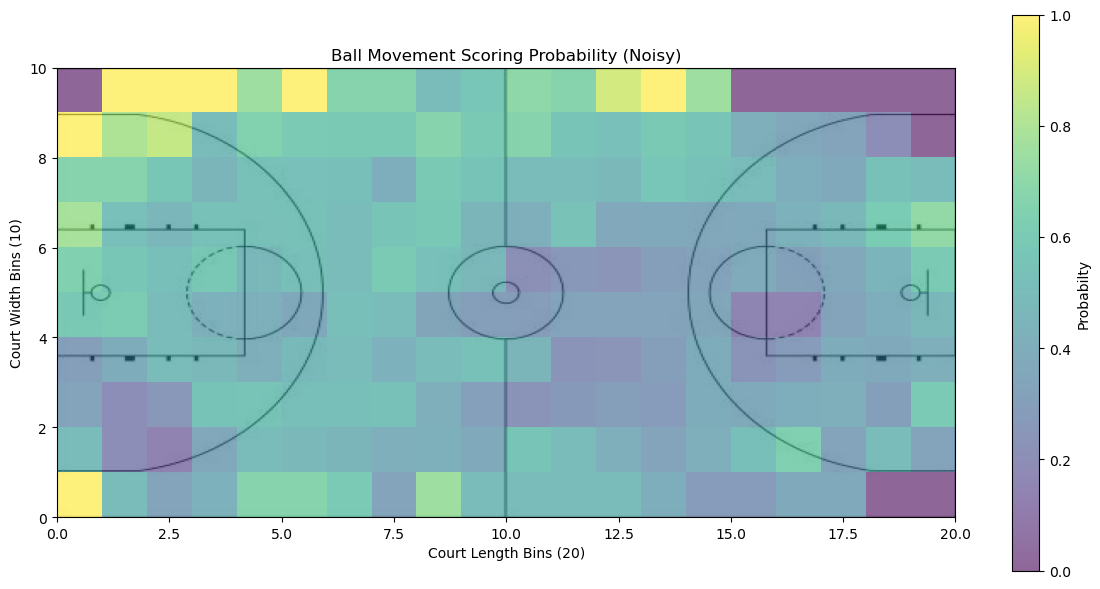

In [37]:
def calculate_score_probability_matrix(df, x_bins=20, y_bins=10):

    # Bin positions
    df['x_bin'] = np.clip((df['x'] / 94 * x_bins).astype(int), 0, x_bins - 1)
    df['y_bin'] = np.clip((df['y'] / 50 * y_bins).astype(int), 0, y_bins - 1)

    # Initialize per-bin possession counters
    total_possessions = np.zeros((x_bins, y_bins))
    scored_possessions = np.zeros((x_bins, y_bins))

    # Count unique possessions that entered each bin
    grouped = df.groupby("possession_number")
    for _, group in grouped:
        visited = set(zip(group['x_bin'], group['y_bin']))
        scored = group['scored'].iloc[0]  # same for all rows in a possession
        for xb, yb in visited:
            total_possessions[xb, yb] += 1
            if scored == 1:
                scored_possessions[xb, yb] += 1

    # Compute probability matrix
    with np.errstate(divide='ignore', invalid='ignore'):
        probability_matrix = np.true_divide(scored_possessions, total_possessions)
        probability_matrix[~np.isfinite(probability_matrix)] = 0  # Set NaNs and infs to 0

    return probability_matrix

prob_matrix = calculate_score_probability_matrix(last_rows_in_order)

court_img = Image.open("court.jpg")

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(court_img, extent=[0, 20, 0, 10], aspect='auto')
overlay = ax.imshow(
    prob_matrix.T,
    cmap='viridis',
    origin='lower',
    extent=[0, 20, 0, 10],
    alpha=0.6
)

plt.colorbar(overlay, ax=ax, label='Probabilty')
ax.set_title("Ball Movement Scoring Probability (Noisy)")
ax.set_xlabel("Court Length Bins (20)")
ax.set_ylabel("Court Width Bins (10)")
plt.tight_layout()
plt.show()

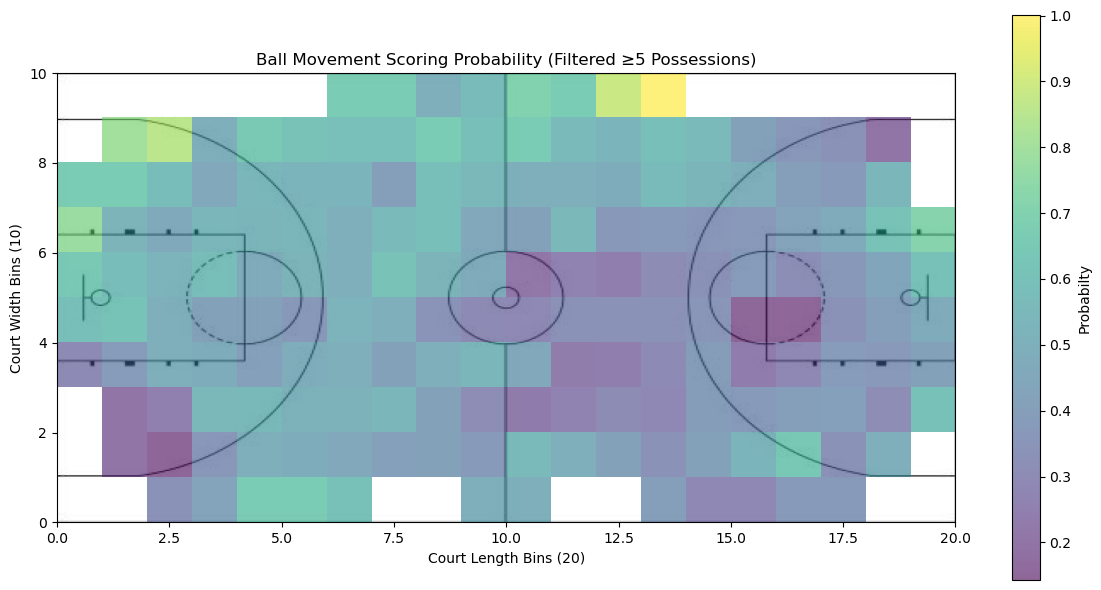

In [38]:
def calculate_score_probability_matrix_filter(df, min_visits, x_bins=20, y_bins=10):

    # Bin positions
    df['x_bin'] = np.clip((df['x'] / 94 * x_bins).astype(int), 0, x_bins - 1)
    df['y_bin'] = np.clip((df['y'] / 50 * y_bins).astype(int), 0, y_bins - 1)

    # Initialize per-bin possession counters
    total_possessions = np.zeros((x_bins, y_bins))
    scored_possessions = np.zeros((x_bins, y_bins))

    # Count unique possessions that entered each bin
    for _, group in df.groupby("possession_number"):
        visited_bins = set(zip(group['x_bin'], group['y_bin']))
        scored = group['scored'].iloc[0]  # same for all rows in a possession
        for xb, yb in visited_bins:
            total_possessions[xb, yb] += 1
            if scored == 1:
                scored_possessions[xb, yb] += 1

    # Calculate conditional probabilities
    with np.errstate(divide='ignore', invalid='ignore'):
        prob_matrix = scored_possessions / total_possessions
        prob_matrix[~np.isfinite(prob_matrix)] = 0

    # Filter out bins with too few possessions
    prob_matrix[total_possessions < min_visits] = np.nan

    return prob_matrix

min_visits = 5

prob_matrix = calculate_score_probability_matrix_filter(last_rows_in_order, min_visits, x_bins=20, y_bins=10)
court_img = Image.open("court.jpg")

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(court_img, extent=[0, 20, 0, 10], aspect='auto')
overlay = ax.imshow(
    prob_matrix.T,
    cmap='viridis',
    origin='lower',
    extent=[0, 20, 0, 10],
    alpha=0.6
)

plt.colorbar(overlay, ax=ax, label='Probabilty')
ax.set_title(f"Ball Movement Scoring Probability (Filtered ≥{min_visits} Possessions)")
ax.set_xlabel("Court Length Bins (20)")
ax.set_ylabel("Court Width Bins (10)")
plt.tight_layout()
plt.show()

In [39]:
# High probability towards the boundaries. Inbound passes?
# Probability is higher than expected in most zones. Filter z-axis? 

## Plotting Possessions to Improve Analysis

The heatmaps are useful, but we can add more context to them before doing breakdown analysis by analyzing plays visually. This will hopefully clear up the picture as to why the ball moves more during non-scoring plays, and as to why plays that move along the bottom side of the court are so effective.

This will also allow us to see how noisy some of our data is, or if it's even tracked correctly.

In [41]:
movement_df.to_csv("movement_csv.csv")

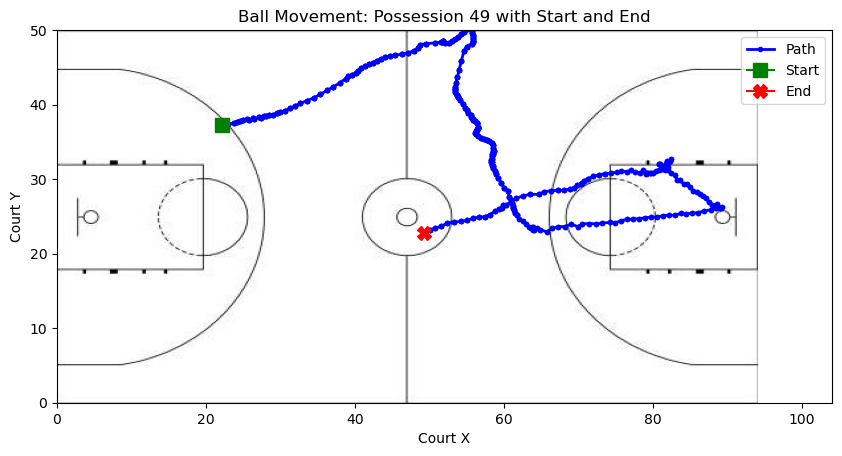

In [42]:
def movement_plot_possession(df, possession, image):
    court_img = mpimg.imread(image)
    
    # Filter a specific possession
    sub_df = df[df["possession_number"] == possession].sort_values(by="time", ascending=False)
    
    # Get start and end positions
    start_x, start_y = sub_df.iloc[0][["x", "y"]]
    end_x, end_y = sub_df.iloc[-1][["x", "y"]]
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(court_img, extent=[0, 94, 0, 50])
    ax.plot(sub_df["x"], sub_df["y"], color="blue", linewidth=2, marker="o", markersize=3, label="Path")
    
    # Start marker
    ax.plot(start_x, start_y, marker="s", color="green", markersize=10, label="Start")
    
    # End marker
    ax.plot(end_x, end_y, marker="X", color="red", markersize=10, label="End")
    
    # Styling
    ax.set_xlim(0, 104)
    ax.set_ylim(0, 50)
    ax.set_title(f"Ball Movement: Possession {possession} with Start and End")
    ax.set_xlabel("Court X")
    ax.set_ylabel("Court Y")
    ax.legend()
    
    plt.show()

movement_plot_possession(last_rows_in_order, 49,"court.jpg")

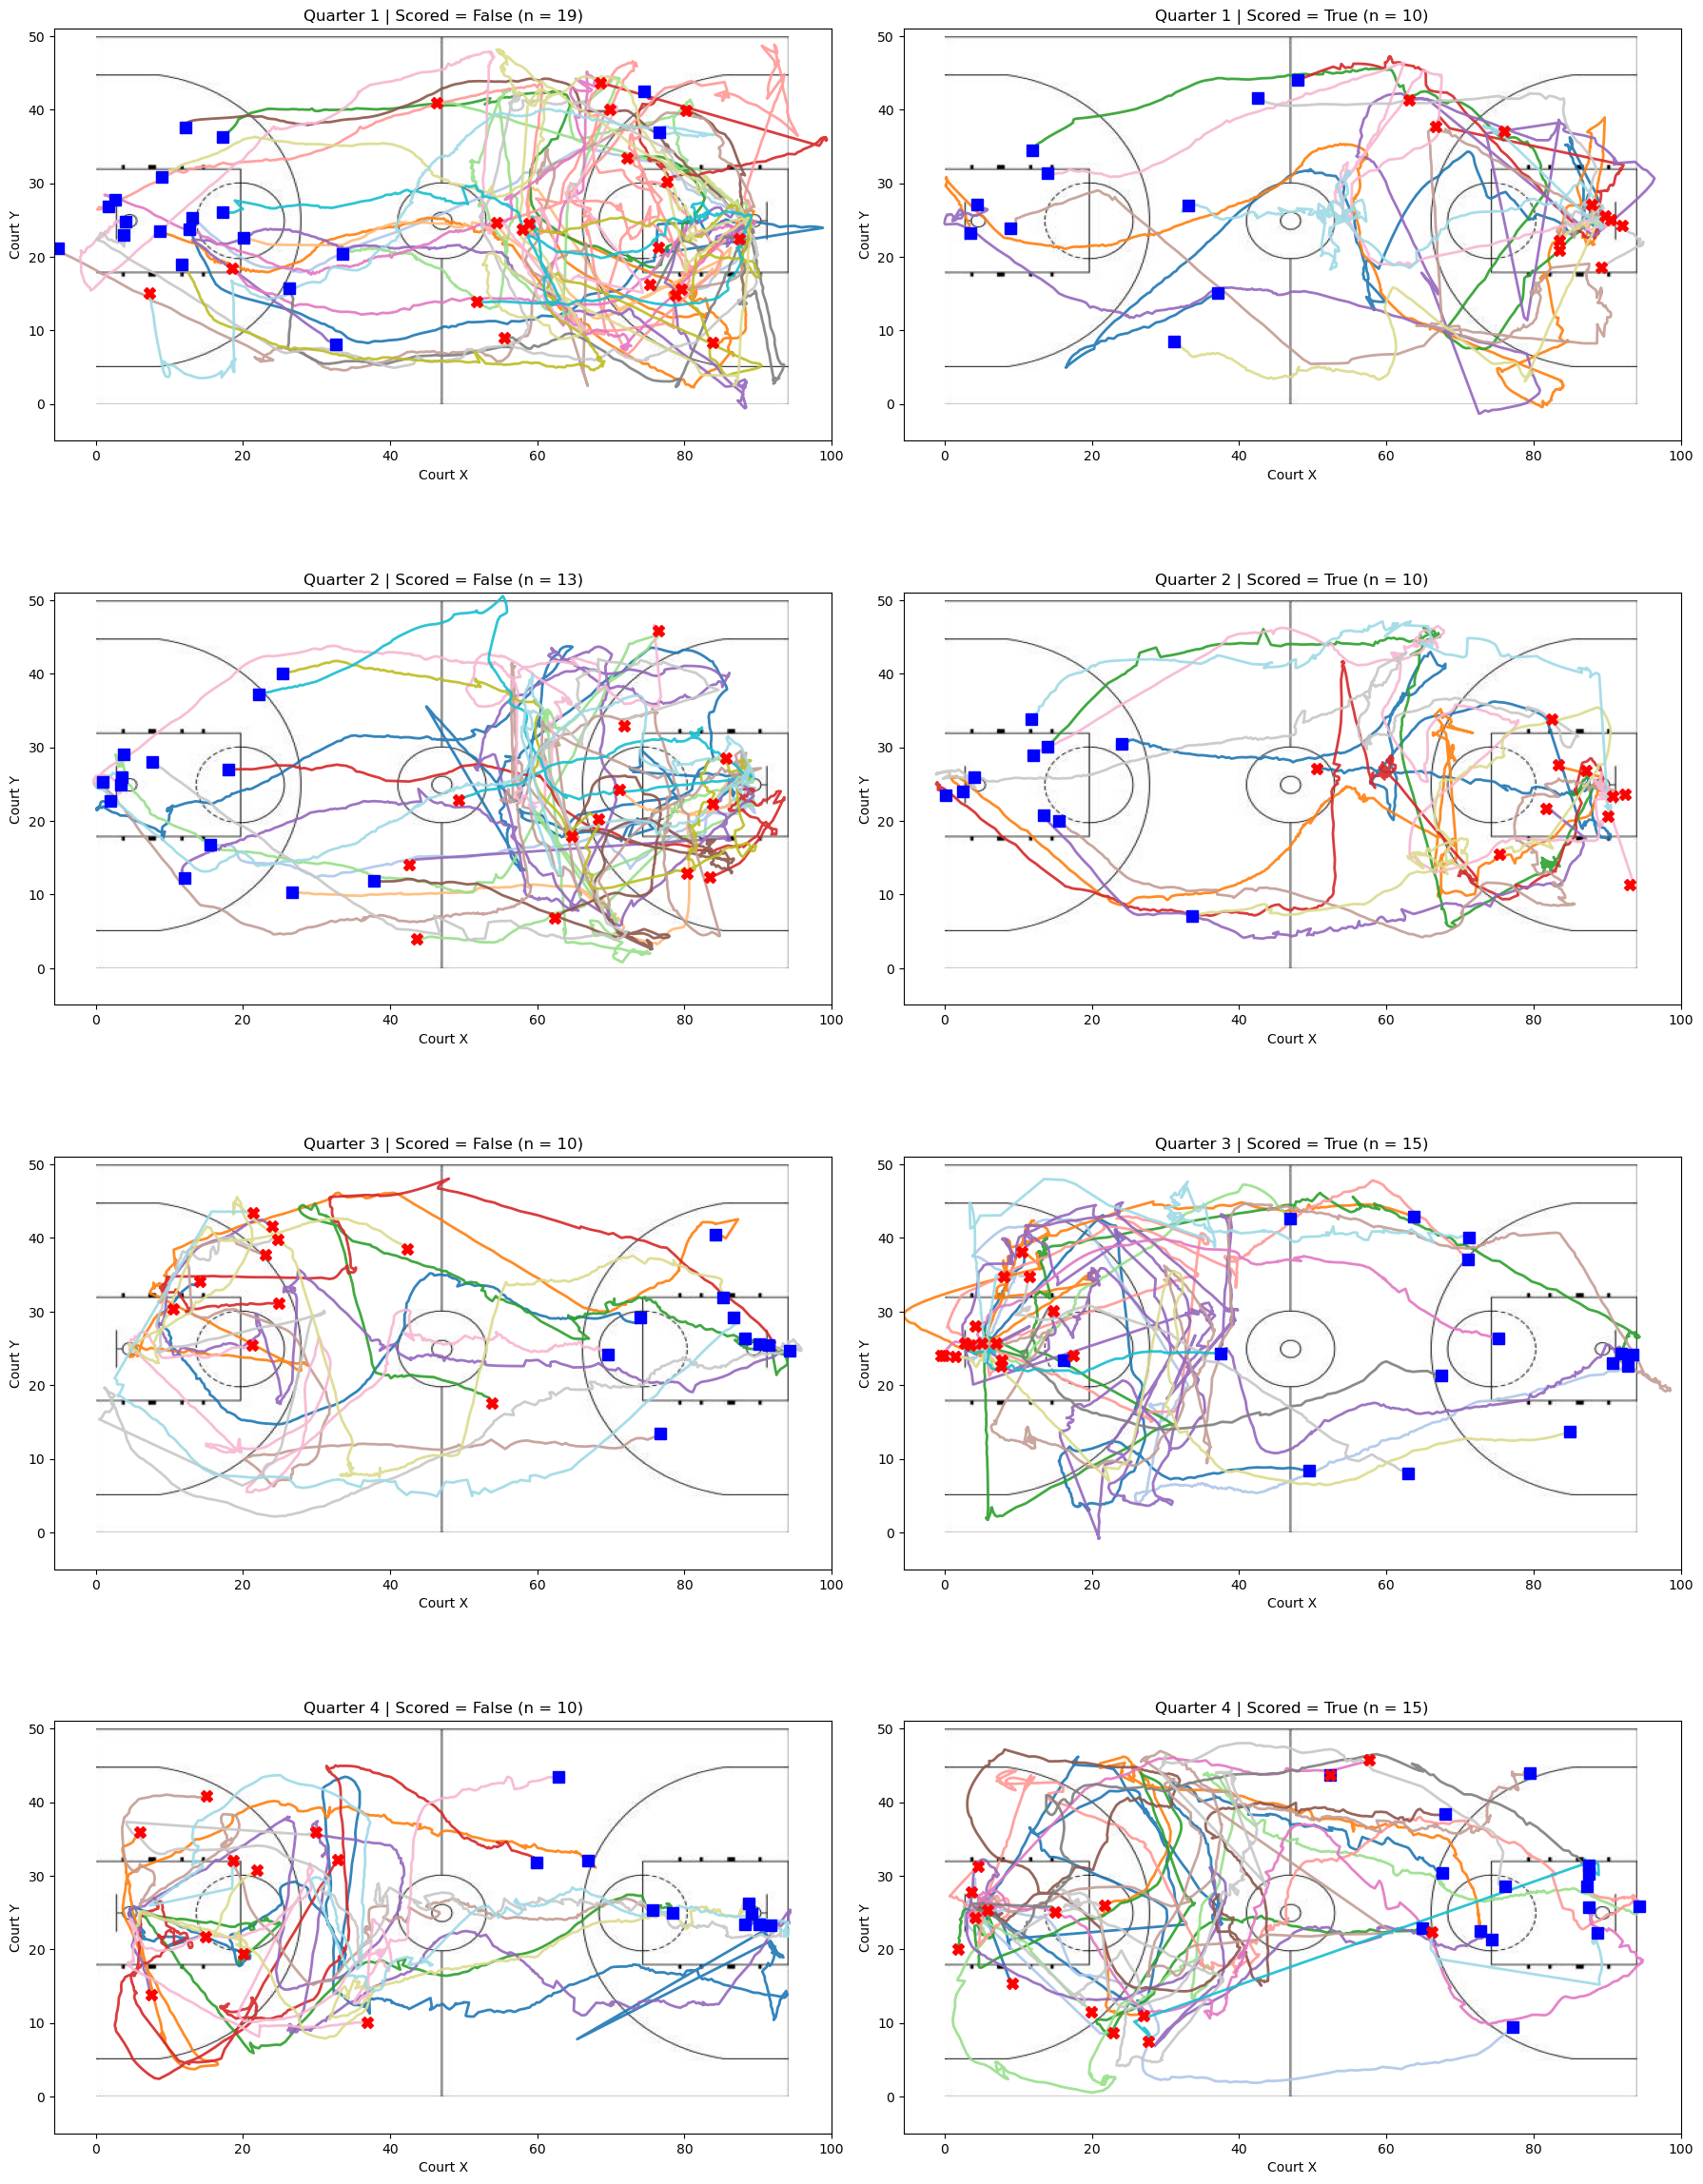

In [43]:
def movement_plot_all_quarters(df, image):
    court_img = mpimg.imread(image)
    fig, axes = plt.subplots(4, 2, figsize=(18, 24))

    # Define fixed court image extent
    court_extent = [0, 94, 0, 50]

    # Compute axis limits based on data, allowing buffer
    x_min, x_max = min(-5, df["x"].min()), max(100, df["x"].max())
    y_min, y_max = min(-5, df["y"].min()), max(51, df["y"].max())

    for row, quarter in enumerate([1, 2, 3, 4]):
        for col, scored in enumerate([0, 1]):
            ax = axes[row, col]
            scored_df = df[(df["period"] == quarter) & (df["scored"] == scored)]
            possession_ids = scored_df["possession_number"].unique()
            possession_count = len(possession_ids)
            cmap = cm.get_cmap('tab20', max(possession_count, 1))

            # Show fixed-size court image
            ax.imshow(court_img, extent=court_extent, zorder=0)

            # Extend the axes beyond court image
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f"Quarter {quarter} | Scored = {bool(scored)} (n = {possession_count})")
            ax.set_xlabel("Court X")
            ax.set_ylabel("Court Y")

            for i, pid in enumerate(possession_ids):
                group = scored_df[scored_df["possession_number"] == pid].sort_values(by="time", ascending=False)
                start_x, start_y = group.iloc[0][["x", "y"]]
                end_x, end_y = group.iloc[-1][["x", "y"]]
                color = cmap(i)
                ax.plot(group["x"], group["y"], color=color, linewidth=2, alpha=0.9, zorder=1)
                ax.plot(start_x, start_y, marker="s", color="blue", markersize=8, zorder=2)
                ax.plot(end_x, end_y, marker="X", color="red", markersize=8, zorder=2)

    plt.tight_layout()
    plt.show()

# Usage
movement_plot_all_quarters(last_rows_in_order, "court.jpg")

In [44]:
last_rows_in_order.describe()

period          time             x             y             z  \
count  92354.000000  92354.000000  92354.000000  92354.000000  92354.000000   
mean       2.438606    371.180613     49.194209     25.406442      4.082943   
std        1.174675    200.290207     25.497675     11.507610      2.734187   
min        1.000000      0.020000     -5.623690     -1.328760      0.000000   
25%        1.000000    194.760000     28.994910     17.074497      2.451030   
50%        2.000000    401.320000     51.568700     24.957925      3.532645   
75%        4.000000    528.030000     68.919380     34.817380      4.675040   
max        4.000000    720.000000     99.345540     50.564640     17.700760   

       possession_start  possession_end  possession_number    scored  \
count      92354.000000    92354.000000       92354.000000   92354.0   
mean         379.517184      361.527026          50.869567  0.408439   
std          200.462132      199.970849          29.028675  0.491548   
min           13.000000        0.000000           1.000000       0.0   
25%          197.000000      184.000000          26.000000       0.0   
50%          419.000000      382.000000          49.000000       0.0   
75%          531.000000      522.000000          79.000000       1.0   
max          720.000000      703.000000         103.000000       1.0   

              x_bin         y_bin  
count  92354.000000  92354.000000  
mean       9.953613      4.584274  
std        5.404281      2.321553  
min        0.000000      0.000000  
25%        6.000000      3.000000  
50%       10.000000      4.000000  
75%       14.000000      6.000000  
max       19.000000      9.000000

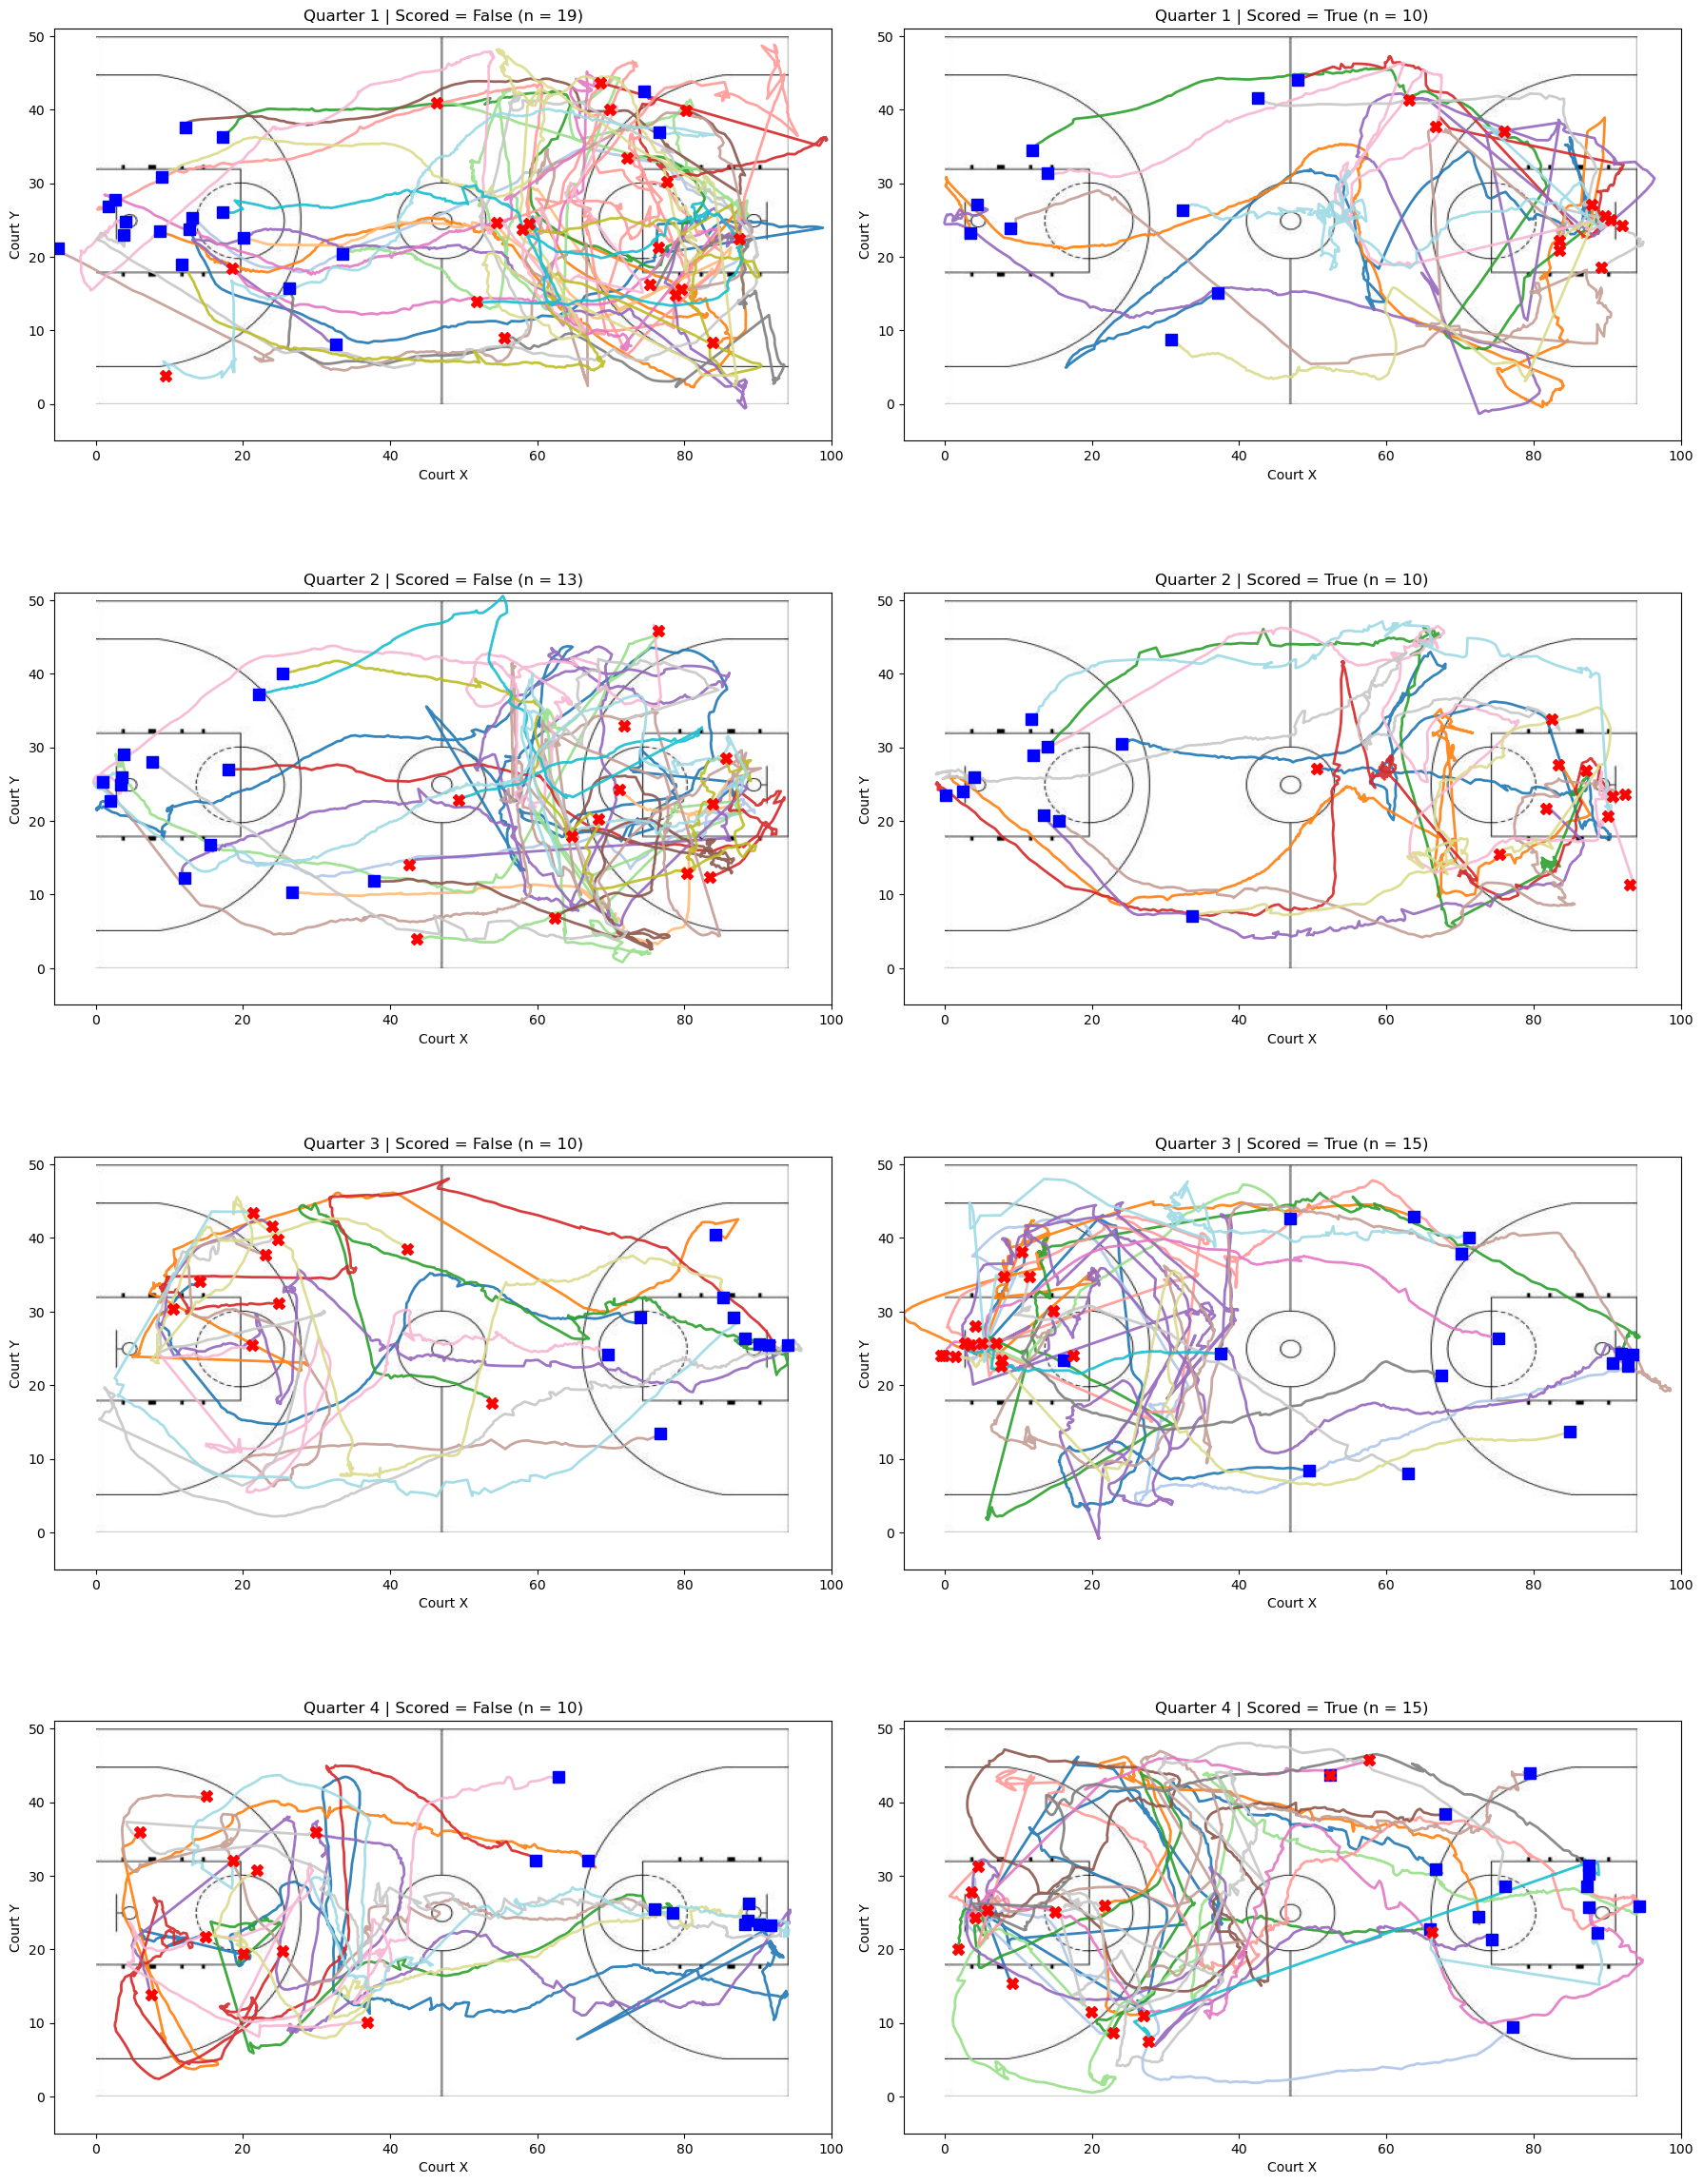

In [88]:
movement_plot_all_quarters(last_rows_in_order[last_rows_in_order["z"] < 9], "court.jpg")

In [136]:
def heat(df, img, ax, title="Ball Movement Heatmap"):
    court_img = Image.open(img)

    court_length = 94  # NBA court length in feet
    court_width = 50   # NBA court width in feet

    x_bins = 20
    y_bins = 10

    # Bin the coordinates
    df['x_bin'] = np.clip((df['x'] / court_length * x_bins).astype(int), 0, x_bins - 1)
    df['y_bin'] = np.clip((df['y'] / court_width * y_bins).astype(int), 0, y_bins - 1)

    # Create heatmap
    heatmap = np.zeros((x_bins, y_bins))
    for _, row in df.iterrows():
        heatmap[row['x_bin'], row['y_bin']] += 1

    # Normalize
    heatmap_normalized = heatmap / np.max(heatmap) if np.max(heatmap) > 0 else heatmap

    # Plot background court
    ax.imshow(court_img, extent=[0, x_bins, 0, y_bins], aspect='auto')

    # Overlay heatmap
    im = ax.imshow(
        heatmap_normalized.T,
        cmap='hot',
        origin='lower',
        extent=[0, x_bins, 0, y_bins],
        alpha=0.6
    )

    ax.set_title(title)
    ax.set_xlabel("Court Length Bins (20)")
    ax.set_ylabel("Court Width Bins (10)")
    
    return im  # Return image object for colorbar

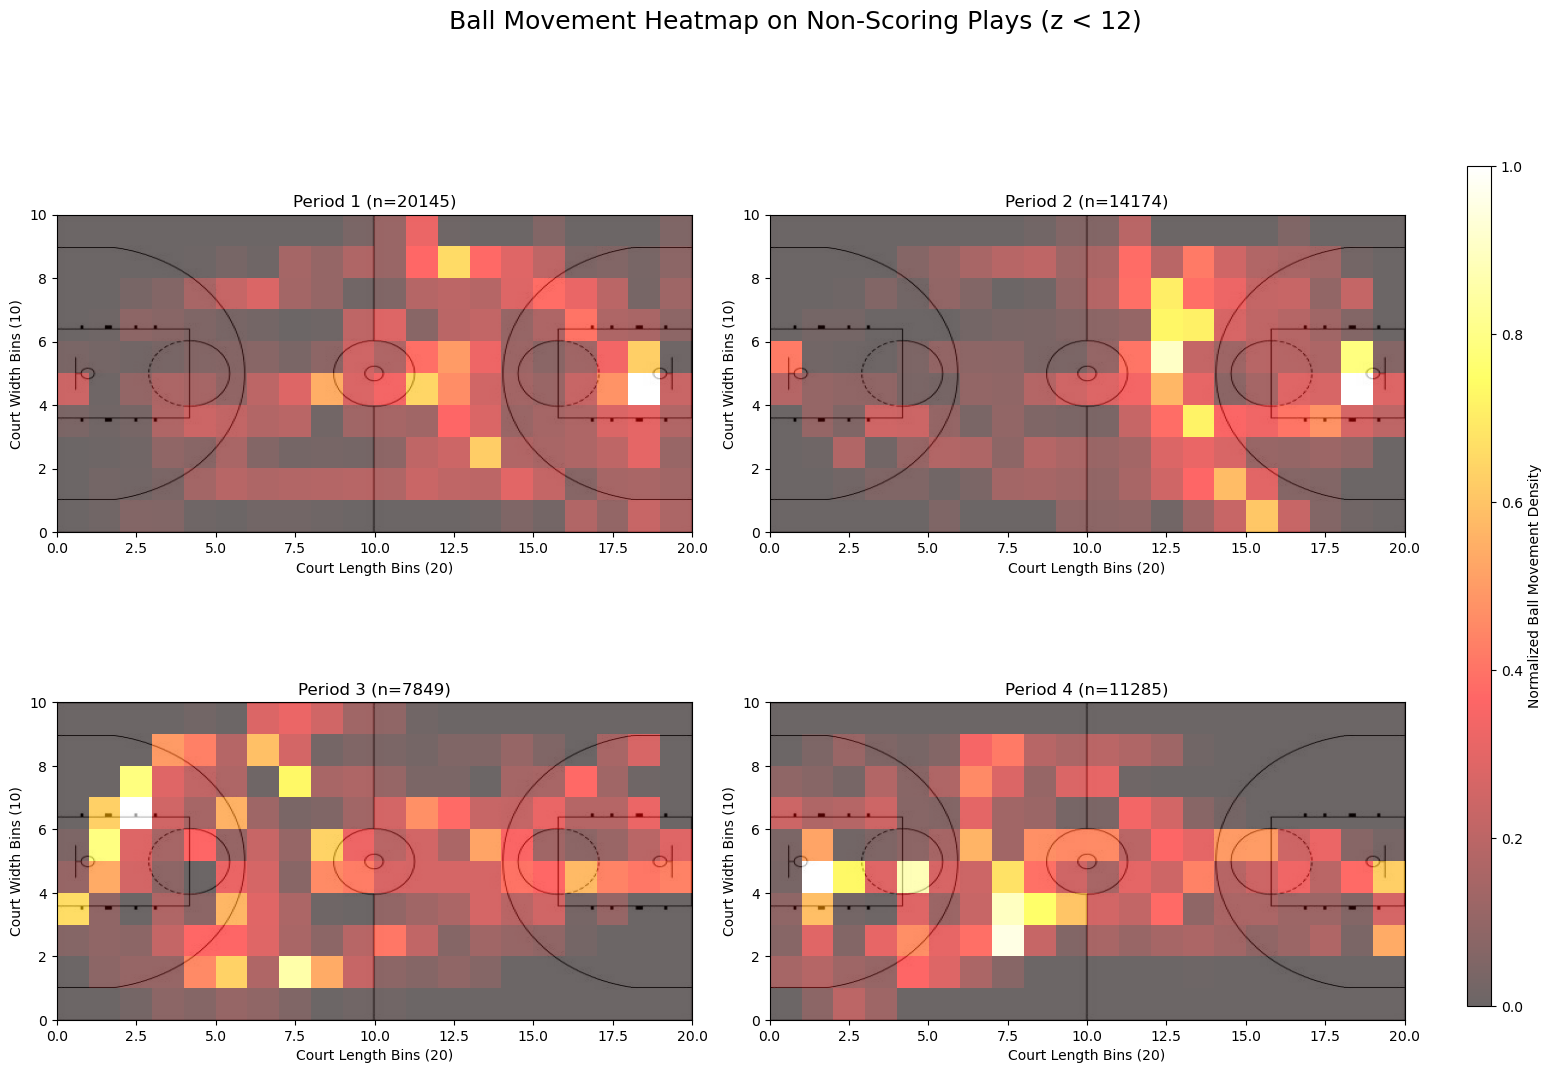

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Ball Movement Heatmap on Non-Scoring Plays (z < 12)", fontsize=18)

# Shared image and heatmap ranges
court_image_path = "court.jpg"
vmin, vmax = 0, 1  # consistent color scale if needed

# Track one of the returned im objects for colorbar
heatmap_images = []

for i, period in enumerate(range(1, 5)):
    ax = axes[i // 2, i % 2]
    subset = last_rows_in_order[
        (last_rows_in_order["scored"] == 0) &
        (last_rows_in_order["z"] < 12) &
        (last_rows_in_order["period"] == period)
    ]
    im = heat(subset, court_image_path, ax, f"Period {period} (n={len(subset)})")
    heatmap_images.append(im)

# Add one shared colorbar (optional)
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])  # leave room for colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # colorbar axes
fig.colorbar(heatmap_images[0], cax=cbar_ax, label="Normalized Ball Movement Density")
plt.show()

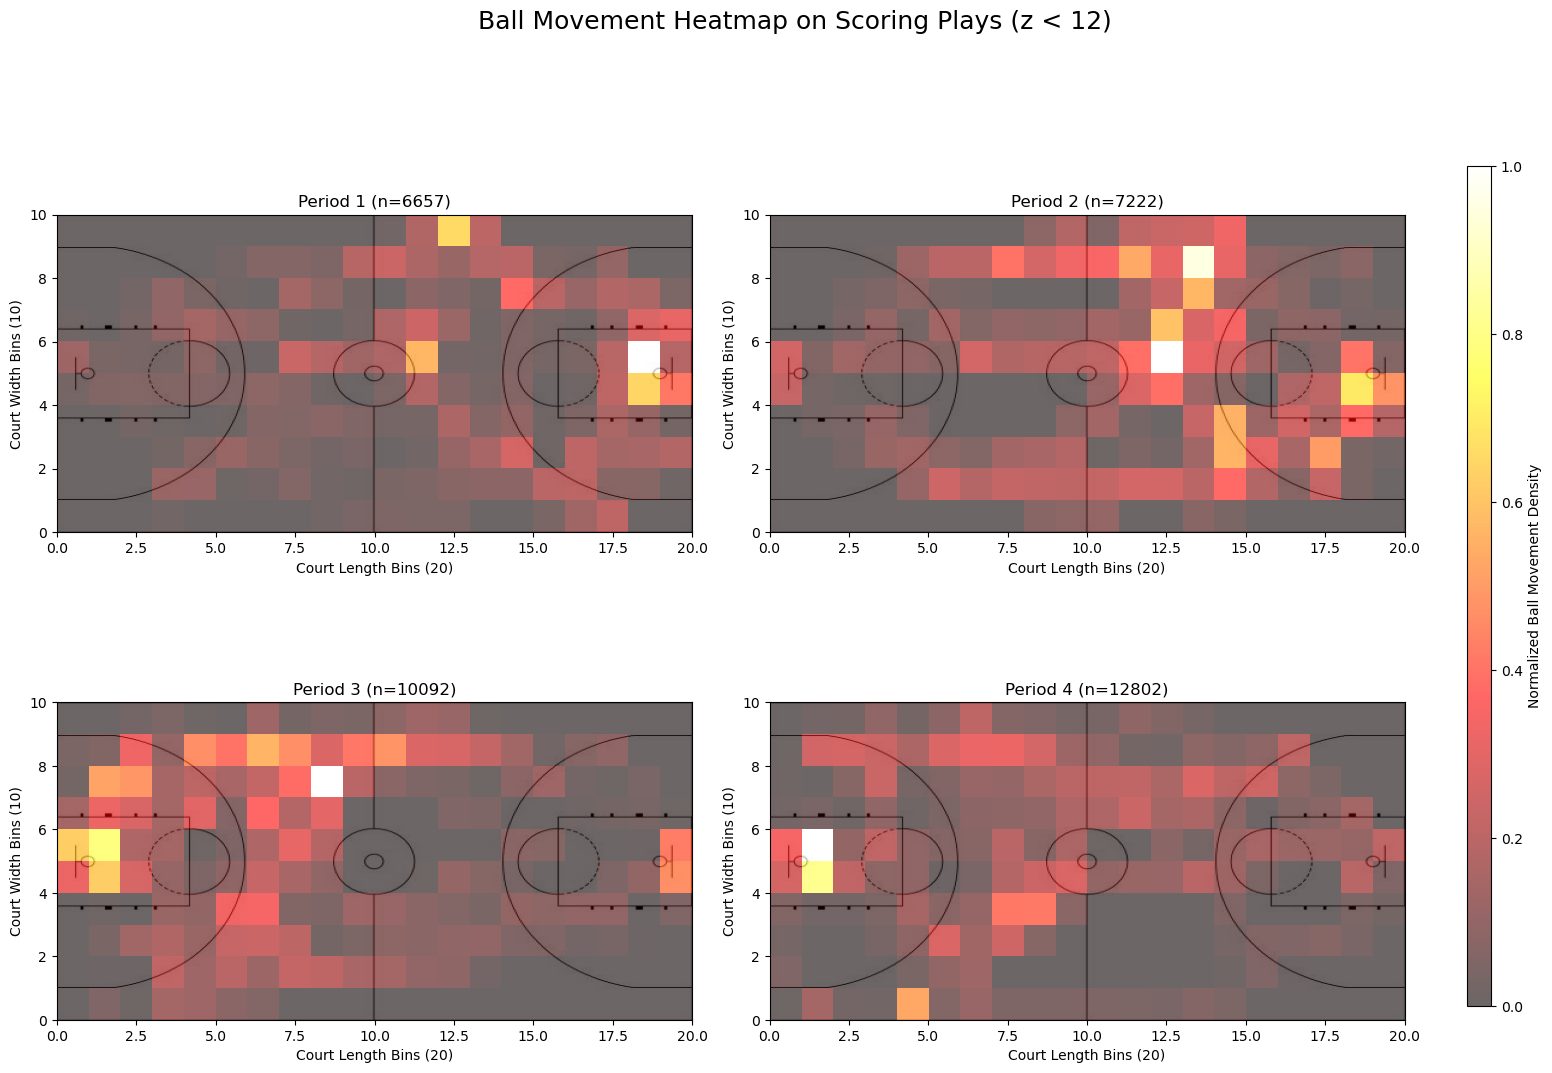

In [144]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Ball Movement Heatmap on Scoring Plays (z < 12)", fontsize=18)

# Shared image and heatmap ranges
court_image_path = "court.jpg"
vmin, vmax = 0, 1  # consistent color scale if needed

# Track one of the returned im objects for colorbar
heatmap_images = []

for i, period in enumerate(range(1, 5)):
    ax = axes[i // 2, i % 2]
    subset = last_rows_in_order[
        (last_rows_in_order["scored"] == 1) &
        (last_rows_in_order["z"] < 12) &
        (last_rows_in_order["period"] == period)
    ]
    im = heat(subset, court_image_path, ax, f"Period {period} (n={len(subset)})")
    heatmap_images.append(im)

# Add one shared colorbar (optional)
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])  # leave room for colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # colorbar axes
fig.colorbar(heatmap_images[0], cax=cbar_ax, label="Normalized Ball Movement Density")
plt.show()

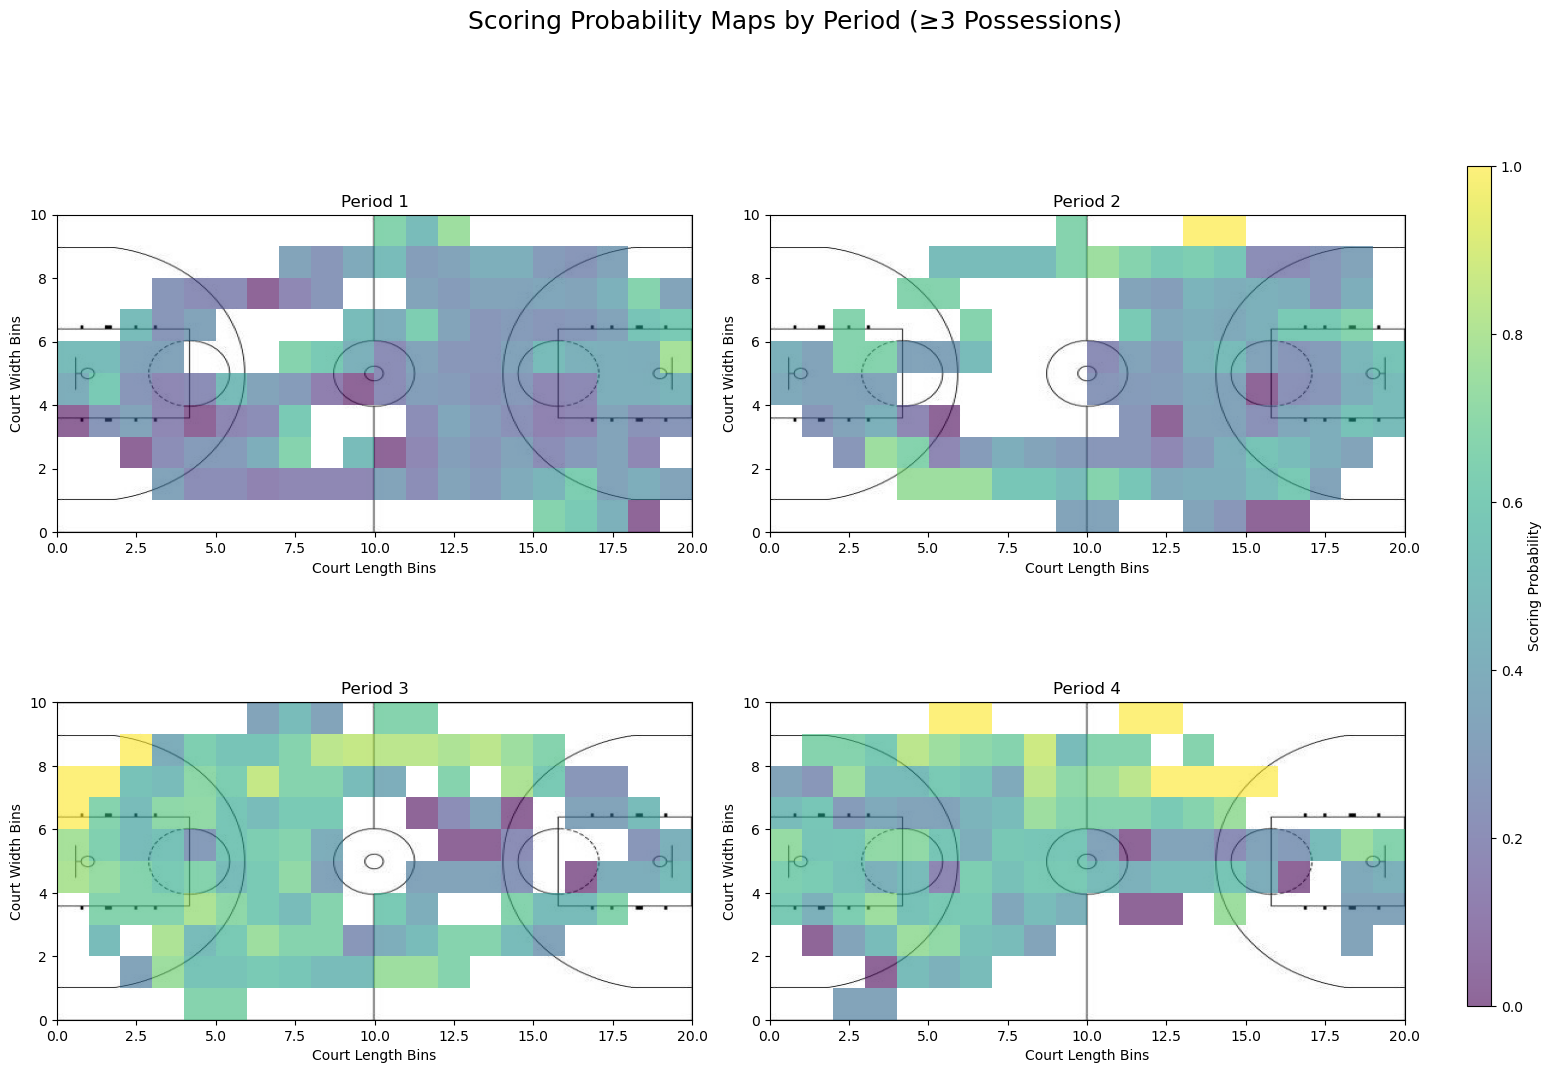

In [154]:
min_visits = 3
x_bins = 20
y_bins = 10
court_img = Image.open("court.jpg")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f"Scoring Probability Maps by Period (≥{min_visits} Possessions)", fontsize=18)

prob_maps = []  # to store overlay handles for shared colorbar

for i, period in enumerate(range(1, 5)):
    ax = axes[i // 2, i % 2]
    subset = last_rows_in_order[last_rows_in_order["period"] == period]

    prob_matrix = calculate_score_probability_matrix_filter(subset, min_visits, x_bins, y_bins)

    # Plot court image
    ax.imshow(court_img, extent=[0, x_bins, 0, y_bins], aspect='auto')

    # Overlay probability heatmap
    overlay = ax.imshow(
        prob_matrix.T,
        cmap='viridis',
        origin='lower',
        extent=[0, x_bins, 0, y_bins],
        alpha=0.6,
        vmin=0, vmax=1  # for consistent color scale across plots
    )

    ax.set_title(f"Period {period}")
    ax.set_xlabel("Court Length Bins")
    ax.set_ylabel("Court Width Bins")
    prob_maps.append(overlay)

# Add shared colorbar without overlapping subplots
plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(prob_maps[0], cax=cbar_ax, label="Scoring Probability")

plt.show()